In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:48: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:48: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:51: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [33]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [34]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')
sector_rtns['All']=np.log(cleansed.resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """


In [35]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)
sector_portfolio_sorts['All']=quantile_portfolios_annual(data,cleansed,2)

In [36]:
factors=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors[s]=sector_portfolio_sorts[s]['1']-sector_portfolio_sorts[s]['0']


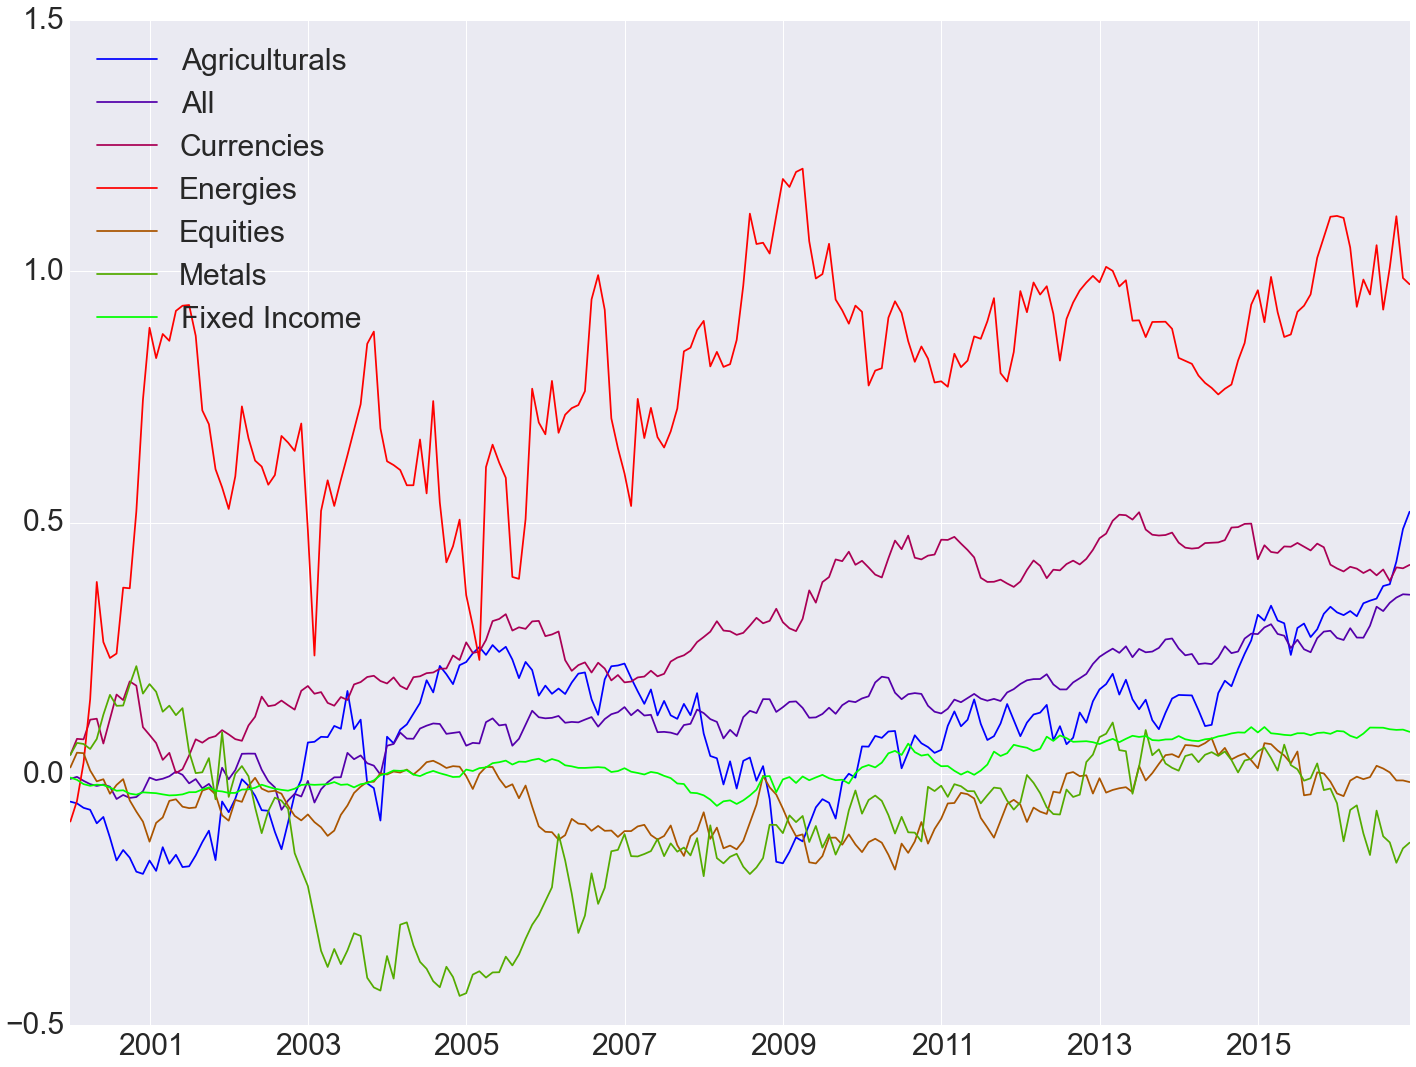

In [37]:
factors.cumsum().plot(colormap='brg')

In [38]:
final_res=pd.DataFrame()
betas_res=pd.DataFrame()
alpha={}
tstat={}
for sec in ['All']:
    ind=factors.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['AA']=res.params *100
        betas_res['AA_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['Amihud Annual']=res.params
final_res['Amihud Annual T']=res.tvalues

# FHT Annual portfolio sorts

In [39]:
FHT=calculate_FHT(cleansed)
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(FHT)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [40]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)
sector_portfolio_sorts['All']=quantile_portfolios_annual(FHT,cleansed,2)

In [41]:
factors_FHT=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors_FHT[s]=sector_portfolio_sorts[s]['1']-sector_portfolio_sorts[s]['0']


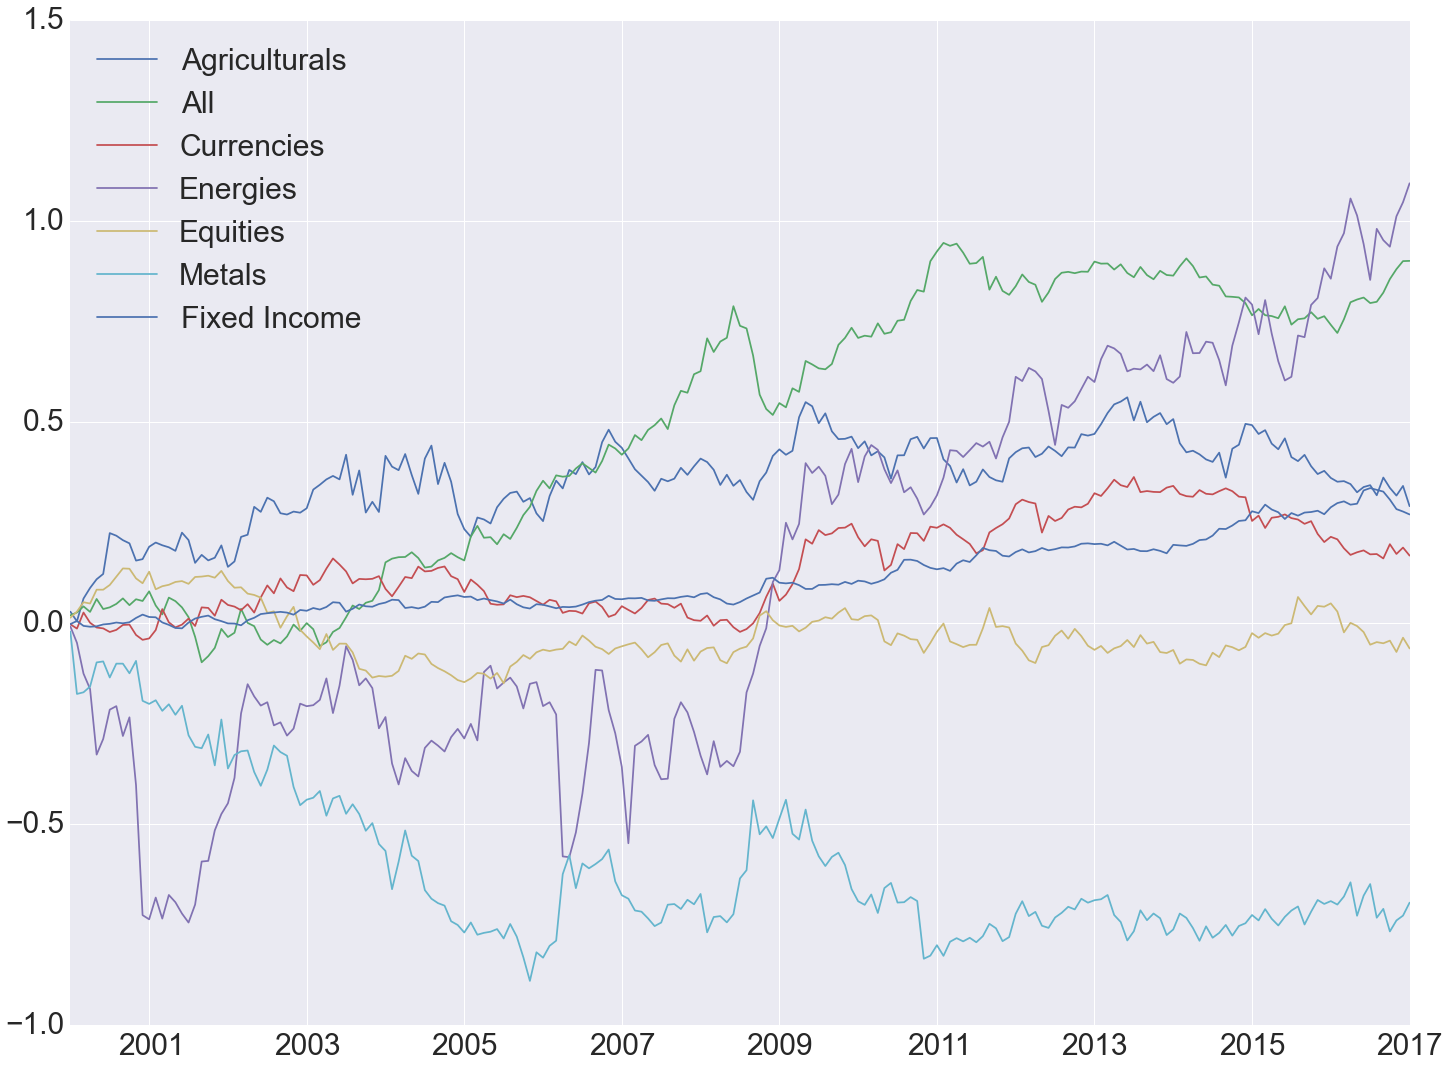

In [42]:
factors_FHT['2000':].cumsum().plot()

In [43]:
alpha={}
tstat={}
for sec in ['All']:
    ind=factors_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_FHT[sec]['2000':'2016'],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['FA']=res.params  *100
        betas_res['FA_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['FHT Annual']=res.params
final_res['FHT Annual T']=res.tvalues

In [44]:
res.params

VAL             -0.093502
MOM             -0.105062
Market Return    0.932248
const            0.002925
dtype: float64

# Monthly portoflio sorts

In [45]:
amihud_monthly = read_monthly(amihud=True)

In [46]:
factors_monthly=pd.DataFrame()
for s in amihud_monthly.keys():
    factors_monthly[s]=amihud_monthly[s]['1']-amihud_monthly[s]['0']


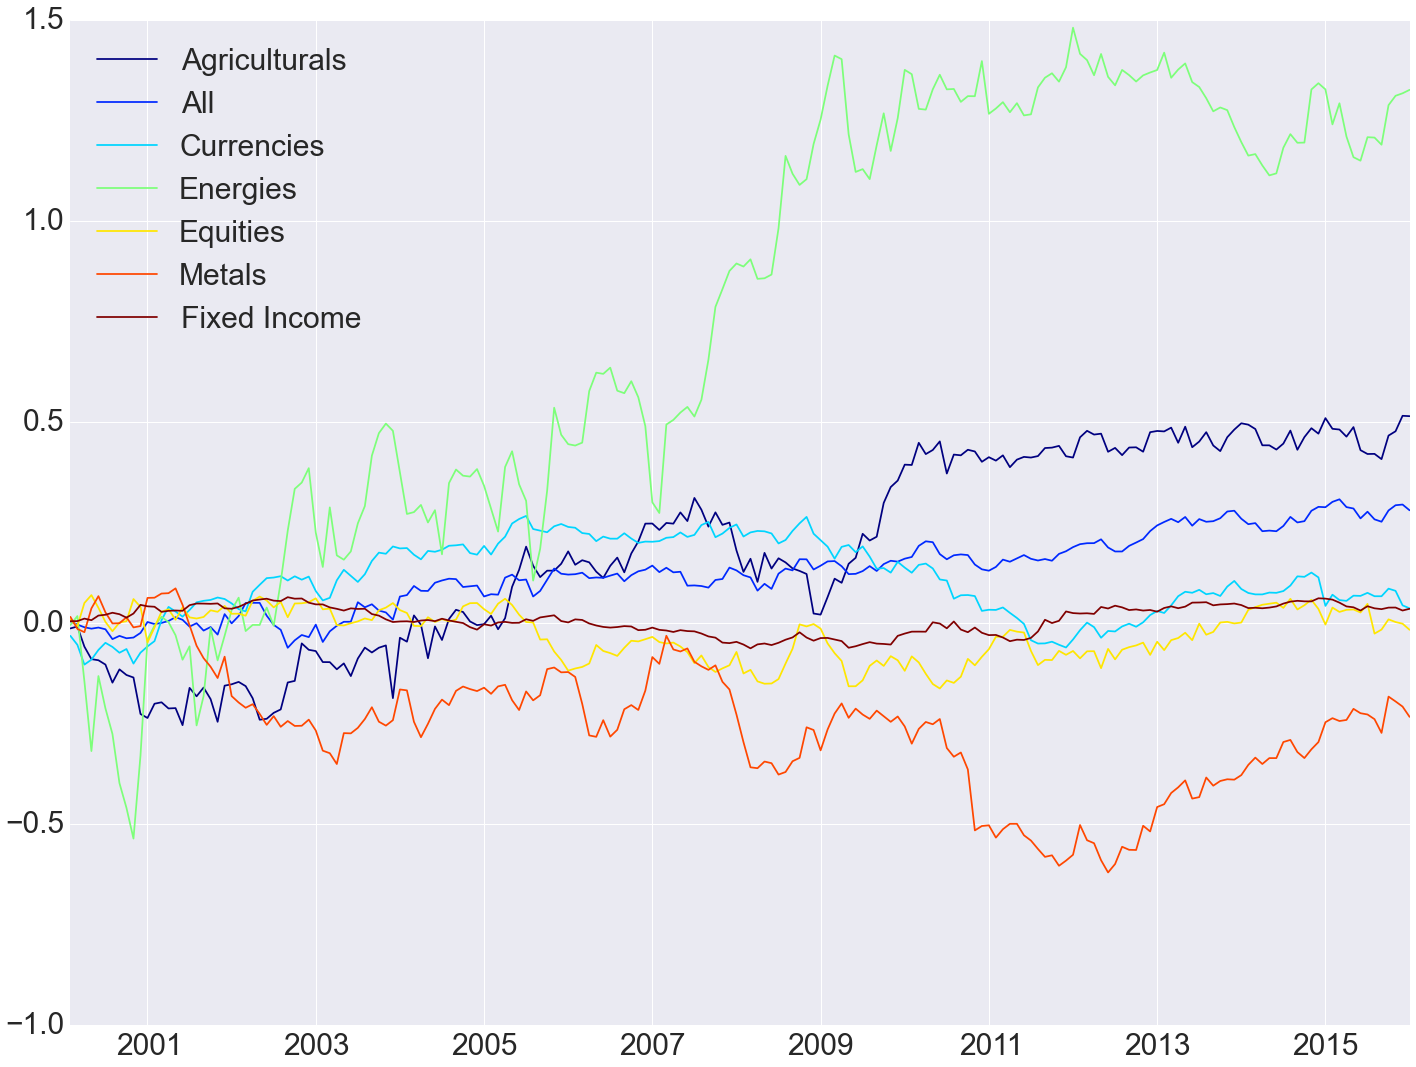

In [59]:
factors_monthly.cumsum().plot(colormap='jet')

In [48]:
alpha={}
tstat={}
for sec in ['All']:
    ind=factors_monthly['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_monthly[sec].loc[ind],reges.loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['AM']=res.params  *100
        betas_res['AM_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['Amihud Monthly']=res.params
final_res['Amihud Monthly T']=res.tvalues

In [58]:
final_res.round(2).T

,VAL,MOM,Market Return,const
Amihud Annual,0.05,-0.03,0.02,0.00
Amihud Annual T,0.63,-0.38,0.42,1.43
FHT Annual,-0.09,-0.11,0.93,0.00
FHT Annual T,-1.61,-1.51,11.42,2.86
Amihud Monthly,0.03,-0.05,0.01,0.00
Amihud Monthly T,0.35,-0.63,0.23,1.27
FHT Monthly,-0.14,-0.13,0.13,0.00
FHT Monthly T,-1.42,-1.89,2.63,0.08


# Monthly FHT

In [50]:
FHT_monthly = read_monthly(amihud=False)

In [51]:
factors_monthly_FHT=pd.DataFrame()
for s in FHT_monthly.keys():
    factors_monthly_FHT[s]=FHT_monthly[s]['1']-FHT_monthly[s]['0']


In [52]:
alpha={}
tstat={}
for sec in ['All']:
    ind=factors_monthly_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_monthly_FHT[sec].loc[ind],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['FM']=res.params  *100
        betas_res['FM_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['FHT Monthly']=res.params
final_res['FHT Monthly T']=res.tvalues

In [53]:
final_res

,Amihud Annual,Amihud Annual T,FHT Annual,FHT Annual T,Amihud Monthly,Amihud Monthly T,FHT Monthly,FHT Monthly T
VAL,0.045939,0.632466,-0.093502,-1.605031,0.025490,0.345859,-0.141162,-1.421470
MOM,-0.028917,-0.381899,-0.105062,-1.505337,-0.049579,-0.634401,-0.133702,-1.892821
Market Return,0.022377,0.419836,0.932248,11.416015,0.012075,0.225954,0.132644,2.629544
const,0.001630,1.430718,0.002925,2.858574,0.001503,1.268916,0.000100,0.082577


In [54]:
betas_res

,AA,AA_T,FA,FA_T,AM,AM_T,FM,FM_T
VAL,4.593929,0.632466,-9.350182,-1.605031,2.549009,0.345859,-14.116156,-1.421470
MOM,-2.891696,-0.381899,-10.506204,-1.505337,-4.957931,-0.634401,-13.370211,-1.892821
Market Return,2.237707,0.419836,93.224843,11.416015,1.207522,0.225954,13.264422,2.629544
const,0.162988,1.430718,0.292464,2.858574,0.150338,1.268916,0.009959,0.082577


# Alpha values 

$$r_{liquidity,t} = \alpha + \beta_1 r_{AssetClass,t} + \beta_2 MOM_{AssetClass,t} +
\beta_3 VAL_{AssetClass,t} + \varepsilon_t $$

In [55]:
print(final_res.T.round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &   VAL &   MOM &  Market Return &  const \\
\midrule
Amihud Annual    &  0.05 & -0.03 &           0.02 &   0.00 \\
Amihud Annual T  &  0.63 & -0.38 &           0.42 &   1.43 \\
FHT Annual       & -0.09 & -0.11 &           0.93 &   0.00 \\
FHT Annual T     & -1.61 & -1.51 &          11.42 &   2.86 \\
Amihud Monthly   &  0.03 & -0.05 &           0.01 &   0.00 \\
Amihud Monthly T &  0.35 & -0.63 &           0.23 &   1.27 \\
FHT Monthly      & -0.14 & -0.13 &           0.13 &   0.00 \\
FHT Monthly T    & -1.42 & -1.89 &           2.63 &   0.08 \\
\bottomrule
\end{tabular}



In [56]:
print final_res.T[[u'Agriculturals', u'Currencies', u'Energies', u'Equities',
       u'Fixed Income', u'Metals', u'All']].round(2).to_latex()


KeyError: "[u'Agriculturals' u'Currencies' u'Energies' u'Equities' u'Fixed Income'\n u'Metals' u'All'] not in index"

# These results are so bad from the beta's to the factors point of view from all markets.  It's just way to high for FHT

I am not going to present them in the results.

In [30]:
print(betas_res.T.round(2)[['const','Market Return','VAL','MOM']].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  const &  Market Return &    VAL &    MOM \\
\midrule
AA   &   0.16 &           2.24 &   4.59 &  -2.89 \\
AA\_T &   1.43 &           0.42 &   0.63 &  -0.38 \\
FA   &   0.29 &          93.22 &  -9.35 & -10.51 \\
FA\_T &   2.86 &          11.42 &  -1.61 &  -1.51 \\
AM   &   0.15 &           1.21 &   2.55 &  -4.96 \\
AM\_T &   1.27 &           0.23 &   0.35 &  -0.63 \\
FM   &   0.01 &          13.26 & -14.12 & -13.37 \\
FM\_T &   0.08 &           2.63 &  -1.42 &  -1.89 \\
\bottomrule
\end{tabular}

